In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from time import time

import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws
from mne.io.edf import read_raw_edf
from mne.datasets import eegbci
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap, Xdawn)
from mne.time_frequency import AverageTFR
from mne.channels import make_standard_montage
from mne.decoding import LinearModel, Vectorizer, get_coef, Scaler, CSP, SPoC, UnsupervisedSpatialFilter
mne.set_log_level('WARNING')

import sklearn
from sklearn.model_selection import StratifiedKFold, cross_val_score, ShuffleSplit, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA, FastICA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import datasets


### Load the Data and number of subjects

In [11]:
# - T0 corresponds to rest
# - T1 corresponds to onset of motion (real or imagined) of
# the left fist (in runs 3, 4, 7, 8, 11, and 12)
# both fists (in runs 5, 6, 9, 10, 13, and 14)
# - T2 corresponds to onset of motion (real or imagined) of
# the right fist (in runs 3, 4, 7, 8, 11, and 12)
# both feet (in runs 5, 6, 9, 10, 13, and 14)

subject = [1] # 1, 4
# [3,7,11] #(open and close left or right fist)
# [4,8,12] #(imagine opening and closing left or right fist)

run_execution = [5, 9, 13]#(open and close both fists or both feet)
run_imagery = [6, 10, 14] #(imagine opening and closing both fists or both feet)

raw_files = []
for person_number in subject:
    for i, j in zip(run_execution, run_imagery):
        raw_files_execution = [read_raw_edf(f, preload=True, stim_channel='auto') for f in eegbci.load_data(person_number, i)]
        raw_files_imagery = [read_raw_edf(f, preload=True, stim_channel='auto') for f in eegbci.load_data(person_number, j)]
        
        raw_execution = concatenate_raws(raw_files_execution)
        raw_imagery = concatenate_raws(raw_files_imagery)

        events, _ = mne.events_from_annotations(raw_execution, event_id=dict(T0=1,T1=2,T2=3))
        mapping = {1:'rest', 2: 'do/feet', 3: 'do/hands'}
        annot_from_events = mne.annotations_from_events(
            events=events, event_desc=mapping, sfreq=raw_execution.info['sfreq'],
            orig_time=raw_execution.info['meas_date'])
        raw_execution.set_annotations(annot_from_events)
        
        events, _ = mne.events_from_annotations(raw_imagery, event_id=dict(T0=1,T1=2,T2=3))
        mapping = {1:'rest', 2: 'imagine/feet', 3: 'imagine/hands'}
        annot_from_events = mne.annotations_from_events(
            events=events, event_desc=mapping, sfreq=raw_imagery.info['sfreq'],
            orig_time=raw_imagery.info['meas_date'])
        raw_imagery.set_annotations(annot_from_events)
        
        raw_files.append(raw_execution)
        raw_files.append(raw_imagery)

In [12]:
display(raw_files)

[<RawEDF | S001R05.edf, 64 x 20000 (125.0 s), ~9.8 MB, data loaded>,
 <RawEDF | S001R06.edf, 64 x 20000 (125.0 s), ~9.8 MB, data loaded>,
 <RawEDF | S001R09.edf, 64 x 20000 (125.0 s), ~9.8 MB, data loaded>,
 <RawEDF | S001R10.edf, 64 x 20000 (125.0 s), ~9.8 MB, data loaded>,
 <RawEDF | S001R13.edf, 64 x 20000 (125.0 s), ~9.8 MB, data loaded>,
 <RawEDF | S001R14.edf, 64 x 20000 (125.0 s), ~9.8 MB, data loaded>]

In [13]:
raw = concatenate_raws(raw_files)
events, event_dict = mne.events_from_annotations(raw)
data = raw.get_data()

# display(raw.info)
# display(event_dict)
# display(raw.ch_names)
# display(data)

In [14]:
#filter any bad channels that were identified to have artifacts
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
print (picks)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


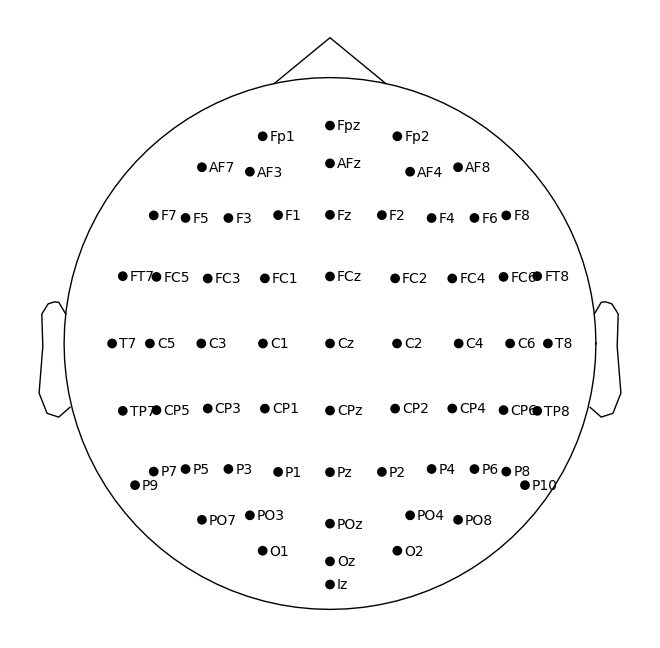

<RawEDF | S001R05.edf, 64 x 120000 (750.0 s), ~58.7 MB, data loaded>

In [15]:
biosemi_montage = mne.channels.make_standard_montage('biosemi64')
biosemi_montage.plot()
plt.show()

eegbci.standardize(raw)  # set channel names
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)

## Visualize the data & apply bandpass filter

/usr/local/lib/python3.10/site-packages/mne/viz/utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


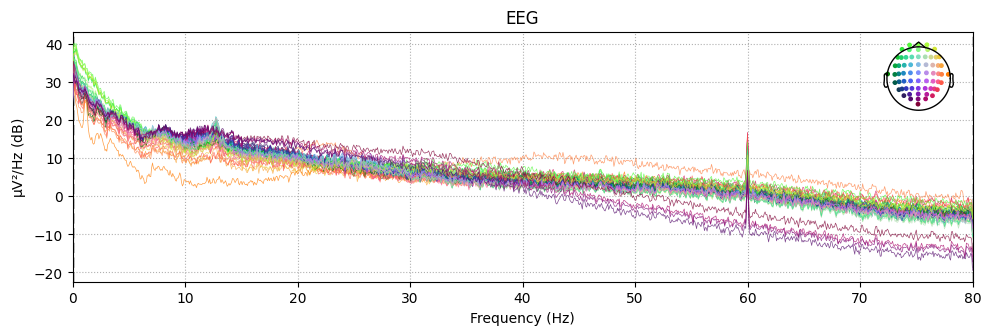

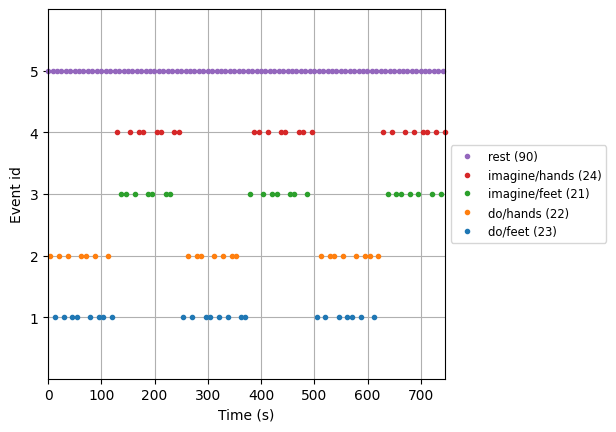

In [16]:
raw.plot_psd(average=False)
plt.show()

fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp, event_id=event_dict)
fig.subplots_adjust(right=0.7)

/usr/local/lib/python3.10/site-packages/mne/viz/utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


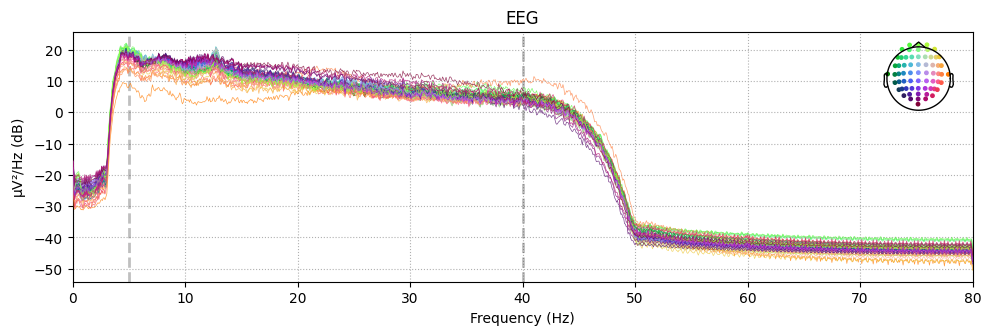

In [17]:
raw.filter(5., 40., fir_design='firwin', skip_by_annotation='edge')
raw.plot_psd(average=False)
plt.show()

## Filter the Data to exclude eye artifacts from 'FPZ' channel

In [18]:
def run_ica(raw, method, fit_params=None):
    raw_corrected = raw.copy()
    n_components = 20
    
    ica = ICA(n_components=20, method=method, fit_params=fit_params, random_state=97)
    t0 = time()
    ica.fit(raw_corrected, picks=picks)
    fit_time = time() - t0
    ica.plot_components()
    plt.show()
    
    eog_indicies, scores= ica.find_bads_eog(raw, ch_name='Fpz', threshold=1.5)
    ica.plot_scores(scores, exclude=eog_indicies)
    ica.exclude.extend(eog_indicies)
    raw_corrected = ica.apply(raw_corrected, n_pca_components = n_components, exclude = ica.exclude)
    
    return raw_corrected

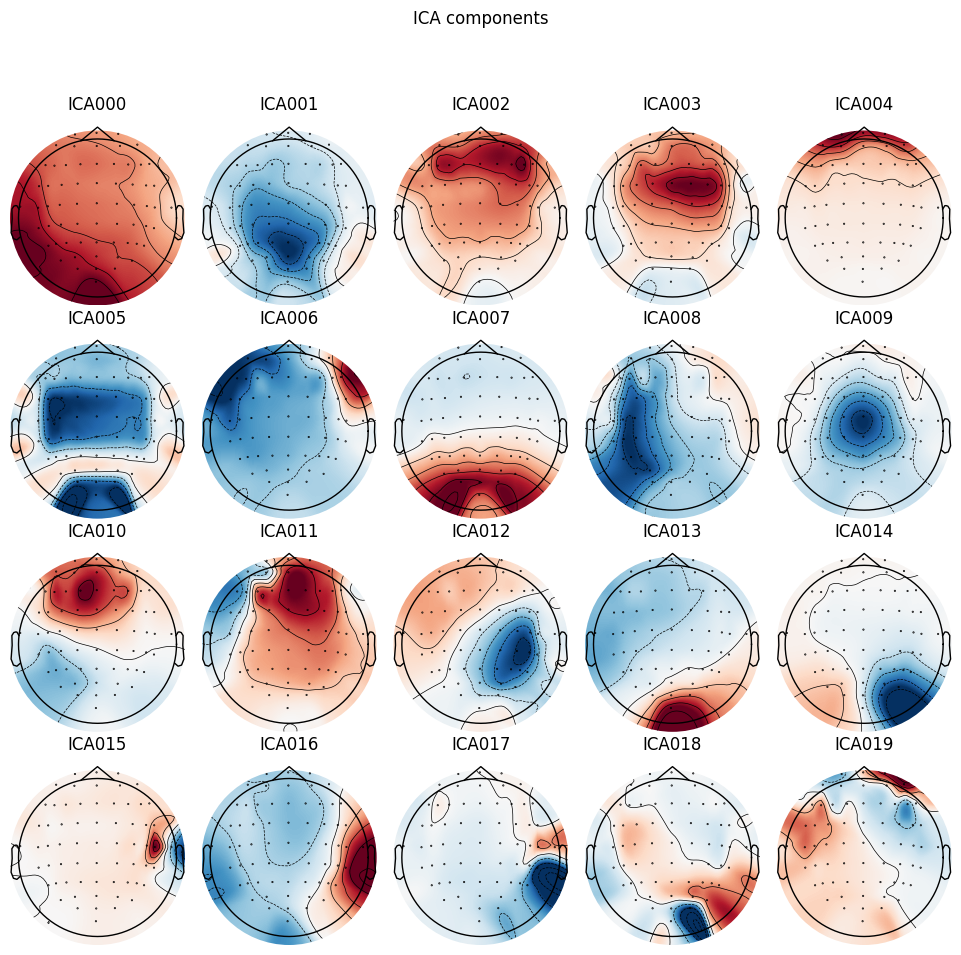

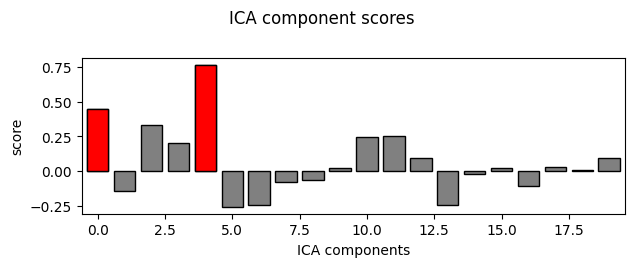

In [19]:
raw_fastica = run_ica(raw, 'fastica')

Number of channels: 64
Total duration: 749.99375 seconds


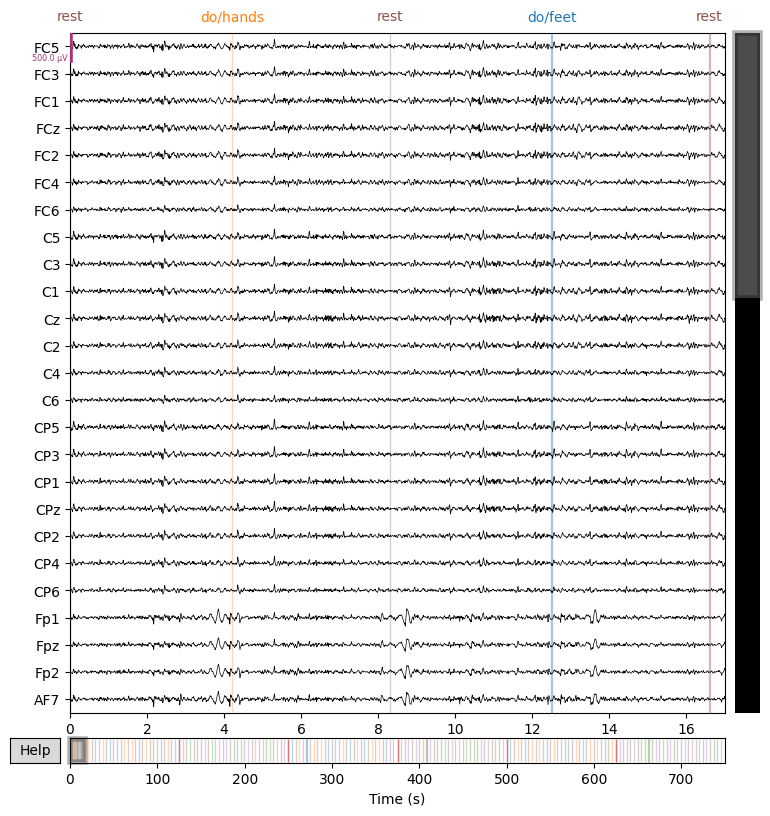

In [21]:
print("Number of channels:", len(raw.ch_names))
print("Total duration:", raw.times[-1], "seconds")
raw.plot(n_channels=25, start=0, duration=17, scalings=dict(eeg=250e-6))
plt.show()

## Isolating the events and converting them to epoches

In [87]:
event_id = {'do/feet': 1, 'do/hands': 2, 'imagine/feet': 3, 'imagine/hands': 4}
tmin, tmax = -1.0, 4.0

events, event_dict = mne.events_from_annotations(raw, event_id=event_id)

epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)



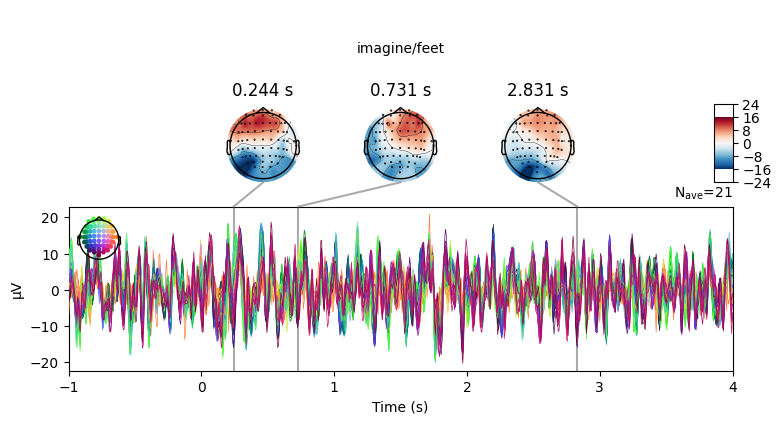

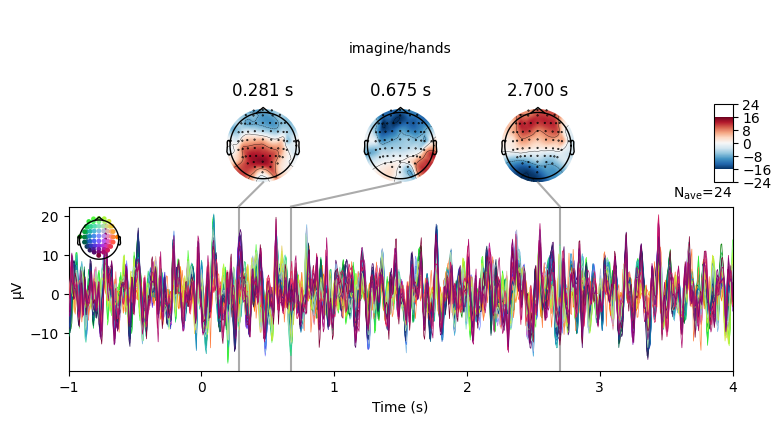

In [28]:
evoked_feet = epochs['imagine/feet'].average()
evoked_hand = epochs['imagine/hands'].average()

evoked_feet.plot_joint(title='imagine/feet')
evoked_hand.plot_joint(title='imagine/hands')
plt.show()

In [52]:
pip install PyQt5

  Obtaining dependency information for PyQt5 from https://files.pythonhosted.org/packages/f2/8a/aa7699436ed898a1cc34724bbb672a879ea51b8067f0ab71843d52f6fcd0/PyQt5-5.15.10-cp37-abi3-macosx_10_13_x86_64.whl.metadata
  Obtaining dependency information for PyQt5-sip<13,>=12.13 from https://files.pythonhosted.org/packages/2c/08/5746a53447b75f4024324e9409d8c17d005ae94596cb8d1a1da7fd702de6/PyQt5_sip-12.13.0-cp310-cp310-macosx_10_9_universal2.whl.metadata
  Obtaining dependency information for PyQt5-Qt5>=5.15.2 from https://files.pythonhosted.org/packages/66/f5/0a684b2b33b1f1dceaf894d4e8a105f523bb08003f81c89a91e509c5f854/PyQt5_Qt5-5.15.11-py3-none-macosx_10_13_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 3.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 3.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.4/144.4 kB 1.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 2

In [106]:
# %matplotlib qt

# times = np.arange(-1, 4, 0.1)
# fig, anim = evoked_feet.plot_image(times=times, ch_type='eeg', frame_rate=2, time_unit='s', blit=False)


In [107]:
# %matplotlib inline
# sns.set(rc={'figure.figsize':(12,8)})


## Model Pipeline Creation:
### [CSP, SPOC] with [LinearDiscriminantAnalysis, LogisticRegression, RandomForestClassifier]

In [137]:
y = epochs.events[:, -1] - 1
X = epochs.get_data()#3D array: the epoch, channels, time points



In [96]:
def pipeline_creation(X, y, transformer1, transformer2, transformer3):
    cv = ShuffleSplit(10, test_size=0.4, random_state=42)

    lda = LinearDiscriminantAnalysis()
    log_reg = LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto')
    rfc = RandomForestClassifier(n_estimators=150, random_state=42)

    scores1 = []
    scores2 = []
    scores3 = []

    pipeline1 = make_pipeline(transformer1, lda)
    pipeline2 = make_pipeline(transformer2, log_reg)
    pipeline3 = make_pipeline(transformer3, rfc)

    scores1 = cross_val_score(pipeline1, X, y, cv=cv, n_jobs=-1)
    scores2 = cross_val_score(pipeline2, X, y, cv=cv, n_jobs=-1)
    scores3 = cross_val_score(pipeline3, X, y, cv=cv, n_jobs=-1)

    print(f"LinearDiscriminantAnalysis: accuracy {scores1.mean()}, std: {scores1.std()}")
    print(f"LogisticRegression        : accuracy {scores2.mean()}, std: {scores2.std()}")
    print(f"RandomForestClassifier    : accuracy {scores3.mean()}, std: {scores3.std()}")


#     csp1.fit_transform(X, y)
#     csp1.plot_patterns(epochs.info, ch_type='eeg', units='patterns (AU)', size=1.5)
#     plt.show()

#     csp2.fit_transform(X, y)
#     csp2.plot_patterns(epochs.info, ch_type='eeg', units='patterns (AU)', size=1.5)
#     plt.show()

#     csp3.fit_transform(X, y)
#     csp3.plot_patterns(epochs.info, ch_type='eeg', units='patterns (AU)', size=1.5)
#     plt.show()


In [95]:
csp1 = CSP(n_components=10, reg=None, log=True)
csp2 = CSP(n_components=10, reg=None, log=True)
csp3 = CSP(n_components=10, reg=None, log=True)

pipeline_creation(X, y, csp1, csp2, csp3)


Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
    Using tolerance 0.00022 (2.2e-16 eps * 64 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00024 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    Using tolerance 0.00025 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
    

    Using tolerance 0.00026 (2.2e-16 eps * 64 dim * 1.8e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
    Using tolerance 0.00023 (2.2e-16 eps * 64 dim * 1.6e+10  max singular value)
    Using tolerance 0.00023 (2.2e-16 eps * 64 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Estimating covariance using EMPIRICAL
Done.
Done.
Computing rank from data with rank=None
    Using tolerance 0.00024 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 6

Computing rank from data with rank=None
    Using tolerance 0.00025 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Computing rank from data with rank=None
Done.
Computing rank from data with rank=None
    Using tolerance 0.00024 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00024 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00021 (2.2e-16 eps 

    Using tolerance 0.00023 (2.2e-16 eps * 64 dim * 1.6e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 0.00024 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
    Using tolerance 0.00024 (2.2e-16 eps * 64 dim * 1.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 0.00027 (2.2e-16 eps * 64 dim * 1.9e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Reducing data rank from 64 -> 64
Estimating covariance using EMPI

In [97]:
csp1 = SPoC(n_components=15, reg='oas', log=True, rank='full')
csp2 = SPoC(n_components=15, reg='oas', log=True, rank='full')
csp3 = SPoC(n_components=15, reg='oas', log=True, rank='full')

pipeline_creation(X, y, csp1, csp2, csp3)



Computing rank from data with rank='full'
Computing rank from data with rank='full'
    MAG: rank 64 from info
    MAG: rank 64 from info
Computing rank from data with rank='full'
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Computing rank from data with rank='full'
Estimating covariance using OAS
    MAG: rank 64 from info
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Reducing data rank from 64 -> 64
Done.
Estimating covariance using OAS
Estimating covariance using OAS
Done.
Done.
Done.
Computing rank from data with rank='full'
Computing rank from data with rank='full'
Computing rank from data with rank='full'
    MAG: rank 64 from info
    MAG: rank 64 from info
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Estimating covariance using OAS
Done.
Done.
Done.
Computing rank from 

Done.
    MAG: rank 64 from info
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
Done.
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank='full'
Computing rank from data with rank='full'
    MAG: rank 64 from info
    MAG: rank 64 from info
Done.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Computing rank from data with rank='full'
Computing rank from data with rank='full'
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    MAG: rank 64 from info
    MAG: rank 64 from info
Computing rank from data with rank='full'
Done.
Reducing data ra

Done.
Done.
Computing rank from data with rank='full'
Computing rank from data with rank='full'
    MAG: rank 64 from info
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank='full'
Done.
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Computing rank from data with rank='full'
Estimating covariance using OAS
Done.
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computin

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank='full'
    MAG: rank 64 from info
Done.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Computing rank from data with rank='full'
Reducing data rank from 64 -> 64
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Estimating covariance using OAS
Computing rank from data with rank='full'
Done.
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank='full'
    MAG: rank 64 from info
Computing rank from data w

Reducing data rank from 64 -> 64
    MAG: rank 64 from info
Estimating covariance using OAS
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Done.
Estimating covariance using OAS
Done.
Done.
Computing rank from data with rank='full'
Computing rank from data with rank='full'
Computing rank from data with rank='full'
    MAG: rank 64 from info
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank='full'
Done.
Done.
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with ran

    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank='full'
Done.
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank='full'
Done.
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank='full'
    MAG: rank 64 from info
Done.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank='full'
Done.
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Done.
Computing rank from data with rank='full'
    MAG: rank 64 fro

    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank='full'
    MAG: rank 64 from info
Done.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Computing rank from data with rank='full'
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    MAG: rank 64 from info

Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank='full'
    MAG: rank 64 from info
Done.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank='full'
Done.
    MAG: rank 64 from info
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance usin

Computing rank from data with rank='full'
Computing rank from data with rank='full'
    MAG: rank 64 from info
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank='full'
Done.
Done.
Computing rank from data with rank='full'
Computing rank from data with rank='full'
    MAG: rank 64 from info
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Done.
Done.
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Computing rank from data with rank='full'
Computing rank from data with rank='full'
Reducin

    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
Computing rank from data with rank='full'
    MAG: rank 64 from info
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Estimating covariance using OAS
Done.
Done.
Computing rank from data with rank='full'
Computing rank from data with rank='full'
    MAG: rank 64 from info
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank='full'
Done.
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 64 from info
Computing rank from data with rank='full'
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Done.
Computing rank from data with rank='full'
Computing rank from data with rank='full'
    MAG: rank 64 from info
    MAG: rank 64 from info
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Reducing data rank from 64